# Automatic Pairwise Causal Discovery (II)

### Post NonLinear causal model (PNL)

Goals: 
- evaluate pairwise methods from causal discovery toolbox. Particularly `PNL`: [post-nonlinear causal model](https://www.cs.helsinki.fi/u/ahyvarin/papers/Zhang16.pdf)
- analize relation between *Gross National Income per capita* (x) and *life expectancy* (y)
- continue analysis started on https://github.com/muoten/causal-discovery-playground/blob/master/automatic_pairwise_causal_discovery_via_cds.ipynb

Data Sources:
-  Information for pair0074: http://webdav.tuebingen.mpg.de/cause-effect/pair0074_des.txt, based on [UNdata](http://data.un.org)
- pair0001 & pair0086: from http://webdav.tuebingen.mpg.de/cause-effect/
  
Libraries
- causal inference: http://webdav.tuebingen.mpg.de/causality/CauseOrEffect_NICA.rar 
- visualization: `matplotlib` and `seaborn`
- other libraries: `pandas`, `numpy`

### Step 1: Load and explore data
#### 1.1.- Load data from `http://webdav.tuebingen.mpg.de/cause-effect`

In [1]:
!wget http://webdav.tuebingen.mpg.de/cause-effect/pair0074.txt -O data/pair0074.txt 2>/dev/null

In [2]:
import pandas as pd
df_xy = pd.read_csv('data/pair0074.txt', sep=' ', names=['x','y'], index_col=False)
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
x    194 non-null int64
y    194 non-null int64
dtypes: int64(2)
memory usage: 3.2 KB


#### 1.2.- Visualization

Histograms in diagonal. Scatterplot off diagonal

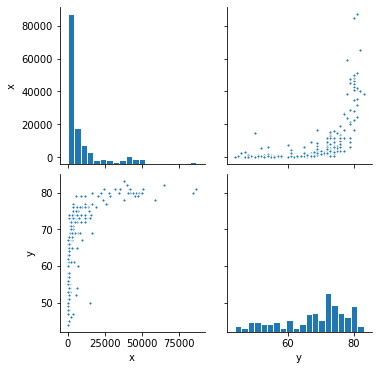

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.PairGrid(df_xy, vars=["x", "y"])
g = g.map_diag(plt.hist, edgecolor="w", bins=20)
g = g.map_offdiag(plt.scatter, edgecolor="w", s=10)

Next visualization shows joint probabilities *p(x,y)* in the left charts and conditional probabilities in the right charts. So we can compare *p(x/yi)* in the upper right charts with *p(y/xi)* in the lower right charts, for 3 given values (thresholds) of y and x respectively.

In [4]:
import numpy as np
from matplotlib.ticker import NullFormatter

def plot_conditional_distributions(x,y,nbins=20,xlabel='x',ylabel='y'):
    # Code derived from https://www.astroml.org/book_figures/chapter3/fig_conditional_probability.html 
    # Copyright (c) 2012-2013, Jacob Vanderplas All rights reserved.
    # License: BSD 
    
    """
Joint and Conditional Probabilities
-----------------------------------

An example of a two-dimensional probability distribution. The color-coded
panel shows p(x, y). The two panels to the left and below show marginal
distributions in x and y. The panels to the right show
the conditional probability distributions p(x|y) for N=4
different values of y (as marked in the left panel).
Note: in the original code there are 3 panels.
"""
    
    MIN_X = min(x)
    MAX_X = max(x)
    MIN_Y = min(y)
    MAX_Y = max(y)

    BINS=nbins
    H, ybins, xbins = np.histogram2d(y, x, bins=BINS)
    H /= np.sum(H)

    #------------------------------------------------------------
    # plot the result
    fig = plt.figure(figsize=(10, 5))

   # define axes
    ax_Pxy = plt.axes((0.2, 0.34, 0.27, 0.52))
    ax_Px = plt.axes((0.2, 0.14, 0.27, 0.2))
    ax_Py = plt.axes((0.1, 0.34, 0.1, 0.52))
    ax_cb = plt.axes((0.48, 0.34, 0.01, 0.52))
    ax_Px_y = [plt.axes((0.65, 0.68, 0.32, 0.16)),
          plt.axes((0.65, 0.50, 0.32, 0.16)),
           plt.axes((0.65, 0.32, 0.32, 0.16)),
            plt.axes((0.65, 0.14, 0.32, 0.16))
          ]
    # set axis label formatters

    ax_Px_y[0].xaxis.set_major_formatter(NullFormatter())
    ax_Px_y[1].xaxis.set_major_formatter(NullFormatter())

    ax_Pxy.xaxis.set_major_formatter(NullFormatter())
    ax_Pxy.yaxis.set_major_formatter(NullFormatter())

    ax_Px.yaxis.set_major_formatter(NullFormatter())
    ax_Py.xaxis.set_major_formatter(NullFormatter())

    # draw the joint probability
    plt.axes(ax_Pxy)
    H *= 1000
    plt.imshow(H, interpolation='nearest', origin='lower', aspect='auto',extent=[MIN_X, MAX_X, MIN_Y, MAX_Y], cmap=plt.cm.binary)

    cb = plt.colorbar(cax=ax_cb)
    cb.set_label('$p(x, y)$')
    plt.text(0, 1.02, r'$\times 10^{-3}$',
         transform=ax_cb.transAxes)

    # draw p(x) distribution
    ax_Px.plot(xbins[1:], H.sum(0), '-k', drawstyle='steps')

    # draw p(y) distribution
    ax_Py.plot(H.sum(1), ybins[1:], '-k', drawstyle='steps')

    # define axis limits
    #ax_Pxy.set_xlim(0, 2)
    ax_Pxy.set_xlim(min(x),max(x))
    #ax_Pxy.set_ylim(0, 2)
    ax_Pxy.set_ylim(min(y), max(y))
    #ax_Px.set_xlim(0, 2)
    ax_Px.set_xlim(min(x), max(x))

    #ax_Py.set_ylim(0, 2)
    ax_Py.set_ylim(min(y), max(y))


    # label axes
    ax_Pxy.set_xlabel('${}$'.format(xlabel))
    ax_Pxy.set_ylabel('${}$'.format(ylabel))
    ax_Px.set_xlabel('${}$'.format(xlabel))
    ax_Px.set_ylabel('$p({})$'.format(xlabel))
    ax_Px.yaxis.set_label_position('right')
    ax_Py.set_ylabel('${}$'.format(ylabel))
    ax_Py.set_xlabel('$p({})$'.format(ylabel))
    ax_Py.xaxis.set_label_position('top')


    # draw marginal probabilities

    N = 4
    iy = [N*BINS//(N+1), 3*BINS//(N+1), 2*BINS//(N+1), 1*BINS//(N+1)]

    colors = 'rgcb'
    axis = ax_Pxy.axis()
    for i in range(N):
        # overplot range on joint probability
        ax_Pxy.plot([MIN_Y, MAX_Y, MAX_X, MIN_X],
                [ybins[iy[i] + 1], ybins[iy[i] + 1],
                 ybins[iy[i]], ybins[iy[i]]], c=colors[i], lw=1)
        Px_y = H[iy[i]] / (H[iy[i]].sum()+0.00001)
        ax_Px_y[i].plot(xbins[1:], Px_y, drawstyle='steps', c=colors[i])
        ax_Px_y[i].yaxis.set_major_formatter(NullFormatter())
        ax_Px_y[i].set_ylabel('p({}|{}={:.1f}){}'.format(xlabel,ylabel,ybins[iy[i]],"\n"*(i%2)))
    ax_Pxy.axis(axis)

    ax_Px_y[(N-1)].set_xlabel('${}$'.format(xlabel))

    ax_Pxy.set_title('Joint Probability')
    ax_Px_y[0].set_title('Conditional Probability')

    plt.show()

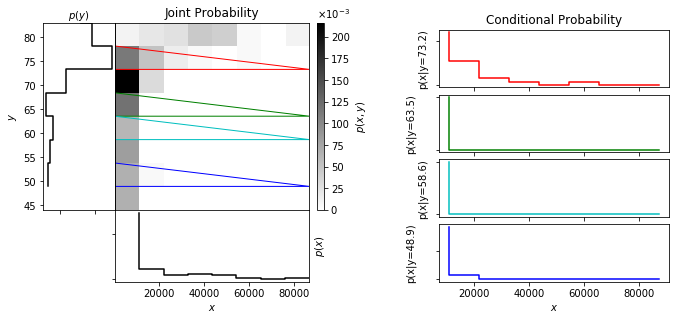

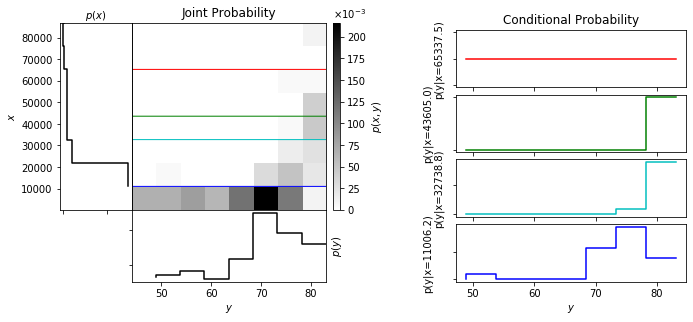

In [5]:
x = np.round(df_xy['x'])
y = np.round(df_xy['y'])
plot_conditional_distributions(x,y,nbins=8)
plot_conditional_distributions(y,x,nbins=8, xlabel='y', ylabel='x')

Visually it seems *P(x|y=k)* have more similar shapes than *P(y|x=k)*. So we could infer, according to the charts, that `y`->`x` is more plausible than `x`->`y`, if the assumption for *Conditional Distribution Similarity* holds. But this (visual) statement is wrong according to our ground truth (`x`->`y`). [More info](http://localhost:8888/notebooks/automatic_pairwise_causal_discovery_via_cds.ipynb#2.2.1.-The-paper)

### Step 2: Pairwise causal discovery

#### 2.1.- Analyze PNL method. Hands on

MatLab code (tested in Octave). To get help: `help CauseOrEffect`
```
function CauseOrEffect(x)
 Use of constrained nonlinear ICA for distinguishing cause from effect.
 Version 1.0, May. 15 2009
 PURPOSE:
       to find which one of xi (i=1,2) is the cause. In particular, this
       function does 1) preprocessing to make xi rather clear to Gaussian,
       2) learn the corresponding 'disturbance' under each assumed causal
       direction, and 3) performs the independence tests to see if the
       assumed cause if independent from the learned disturbance.

 INPUTS:
       x (T*2): has two rows, each of them corresponds to a continuous
       variable. T is the sample size.

 OUTPUTS:
       The statistical tests results will be printed by this function.

 Author: Kun Zhang (Email: kzhang@tuebingen.mpg.de)
 This software is for non commercial use only. It is freeware but not in the public
 domain.
If you find any bugs, please report them to me. Thanks a lot!
```

Let's try:

In [6]:
!echo "cd CauseOrEffect_NICA" > mycommands.m
!echo "addpath(strcat(pwd,'/kernelIndependenceTests'), strcat(pwd,'/information'))">> mycommands.m
!echo "more off" >> mycommands.m
!echo "x = dlmread('../data/pair0074.txt', ' ')(:,1:2)" >> mycommands.m
!echo "CauseOrEffect(x)" >> mycommands.m
!cat mycommands.m

cd CauseOrEffect_NICA
addpath(strcat(pwd,'/kernelIndependenceTests'), strcat(pwd,'/information'))
more off
x = dlmread('../data/pair0074.txt', ' ')(:,1:2)
CauseOrEffect(x)


In [7]:
# Execution can last >5mins
!nohup octave mycommands.m

nohup: se descarta la entrada y se añade la salida a 'nohup.out'


In [8]:
!tail nohup.out

cost =  0.43710969,  improvement =  0.00001625,  epoch  1399
cost =  0.43710563,  improvement =  0.00000406,  epoch  1400
Performing independence tests...
Under x1->x2, estimated mutual information = 0.0118117; 
at significance level alpha = 0.01, threshold = 0.00348222, and testStat = 0.00222082.
Under x1<-x2, estimated mutual information = 0.0495432; 
at significance level alpha = 0.01, threshold = 0.00398639, and testStat = 0.00645327.

 Note: You can see which causal direction is plausible. The smaller the statistic, the more independent the cause and disturbance are.



Output:
```
Performing independence tests...
Under x1->x2, estimated mutual information = -0.00253048;
at significance level alpha = 0.01, threshold = 0.00347221, and testStat = 0.00148853.
Under x1<-x2, estimated mutual information = 0.0539574;
at significance level alpha = 0.01, threshold = 0.00360147, and testStat = 0.00668591.

Note: You can see which causal direction is plausible. The smaller the statistic,the more independent the cause and disturbance are.
>>
```
As `x1->x2` has smaller statistic than `x2->x1`, it seems that `x`->`y` is more plausible. And this is coherent with the established ground truth (and our intuition).

#### 2.2.- Analyze `PNL` method: theory and context

##### 2.2.1.-The papers

- [On the Identifiability of the Post-Nonlinear Causal Model](https://arxiv.org/pdf/1205.2599.pdf) by Zhang et al, 2009
- [Nonlinear Functional Causal Models for Distinguishing Cause from Effect](https://www.cs.helsinki.fi/u/ahyvarin/papers/Zhang16.pdf), Zhang et al, 2016

According to the first paper, there are limited situations in which the PNL causal model is not identifiable, under assumptions like third-order differentiability of functions (f1,f2) and densities (pe2,px1):
>"*Suppose that [previous] assumptions [...] hold. If pe2, the density of the disturbance, is not
Gaussian, nor log-mix-lin-exp, nor a generalized mixture of two exponentials, then the PNL causal model
is identifiable.*"

According to the second paper:
>"*This information-theoretic formulation also leads to a simple intuitive interpretation of the likelihood ratio. It is well known that in the space of probability
distributions of unit variance, differential entropy is maximized by Gaussian
distribution. This is why (negative) differential entropy is often used as a measure
of non-Gaussianity. In our case, we can thus interpret the asymptotic limit of the
log-likelihood ratio in terms of non-Gaussianities and errors in regression*"

>*R → nongaussianity(x) + nongaussianity(residual in x → y) − log(error in x → y) − [nongaussianity(y) + nongaussianity(residual in y → x) − log(error in y → x)]*

>"*Intuitively, this means that*
- *(1) if the non-Gaussianities are negligible, we choose the direction in which the
error in the regression is smaller;*
- *(2) if the errors in the regression are almost equal, we choose the direction of
causality in which the sum of non-Gaussianities of the regressor and residual
is maximized;*
- *(3) in the general case, we have a sum of these two criteria: error in regression
and non-Gaussianity.*"

